# Image Classification of Cars Using Convolutional Neural Network

### Project Part 4: Model Design and Implementation

- Members:
  - Rachel Filderman - raf2dh
  - Jae Yoon Sung - js2yp
  - Congxin (David) Xu - cx2rx

## Requirement
1. Technicality: Does the technical material make sense? Are the things tried reasonable? Are the proposed algorithms or applications clever and interesting? Do the team members convey novel insights about the problem or algorithms?
2. Significance: Did the team members choose an interesting or “real” problem to work on, or only a small “toy” problem? Is this work likely to be useful and have an impact on UVA or the state of Virginia?
3. Novelty: Is this project applying a common technique to a well-studied problem, or is the problem or method relatively unexplored?

## Directions

Describe the experiments that you’ve run, the outcomes, and any error analysis that you’ve done. You should have tried at least one baseline. You should focus only on results that are directly related to the problem. Leaving out your personal opinion, detail your results, and provide solid evidence. Graphs and tables should only be used when there are too much data to efficiently include within the text. If you have a code repository and Jupyter Notebook, make sure you include the URL or supplementary files.

**Design**: In order to highlight these components, it is important that you present a solid discussion regarding the learning from the development of your method: What machine learning techniques have you tried and why? The methods will describe the design and methodology used to complete the study. The general rule of thumb is that readers should be provided with enough detail to replicate the study

## Import Modules

In [ ]:
import pandas
import google.colab
from sklearn.datasets import load_files 
from keras.utils import np_utils
from keras.preprocessing import image
from tqdm import tqdm # progress bar
import tensorflow as tf
import matplotlib.pyplot as plt
import os

## Connect Kaggle with Google Colab
- https://github.com/Kaggle/kaggle-api#api-credentials
- https://www.kaggle.com/general/74235

In [ ]:
# Upload your kaggle.json API file
google.colab.files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rachelfilderman","key":"f6d87c0046fa69f3b377d5decee4e465"}'}

In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder

100% 1.82G/1.83G [00:15<00:00, 44.1MB/s]
100% 1.83G/1.83G [00:15<00:00, 126MB/s] 


In [ ]:
! unzip stanford-car-dataset-by-classes-folder.zip -d kaggle

Streaming output truncated to the last 5000 lines.
  inflating: kaggle/car_data/car_data/train/Chrysler Aspen SUV 2009/04381.jpg  
  inflating: kaggle/car_data/car_data/train/Chrysler Aspen SUV 2009/04688.jpg  
  inflating: kaggle/car_data/car_data/train/Chrysler Aspen SUV 2009/04772.jpg  
  inflating: kaggle/car_data/car_data/train/Chrysler Aspen SUV 2009/05544.jpg  
  inflating: kaggle/car_data/car_data/train/Chrysler Aspen SUV 2009/05728.jpg  
  inflating: kaggle/car_data/car_data/train/Chrysler Aspen SUV 2009/05860.jpg  
  inflating: kaggle/car_data/car_data/train/Chrysler Aspen SUV 2009/06146.jpg  
  inflating: kaggle/car_data/car_data/train/Chrysler Aspen SUV 2009/06157.jpg  
  inflating: kaggle/car_data/car_data/train/Chrysler Aspen SUV 2009/06332.jpg  
  inflating: kaggle/car_data/car_data/train/Chrysler Aspen SUV 2009/06441.jpg  
  inflating: kaggle/car_data/car_data/train/Chrysler Aspen SUV 2009/06447.jpg  
  inflating: kaggle/car_data/car_data/train/Chrysler Aspen SUV 2009/0

In [ ]:
# Load Class Names
names = pandas.read_csv('/content/kaggle/names.csv', header=None)
class_names = names.values.flatten()

## Exploratory Data Analysis

### Loading the Training and Testing Data

In [ ]:
data_dir = "/content/kaggle/car_data/car_data"
batch_size = 32;
# IMPORTANT: Depends on what pre-trained model you choose, 
#   you will need to change these dimensions accordingly
img_height = 224; 
img_width = 224;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + '/train',
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir+ '/test',
    image_size = (img_height, img_width),
    batch_size = batch_size
)

# Preview some pictures
n_rows = 4
n_cols = 4
plt.figure(figsize=(n_cols * 4, n_rows * 4))
for images, labels in train_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[labels[i]], fontsize = 12)
plt.subplots_adjust(wspace=.2, hspace=.2)

## Pre-trained CNN Experiments - Batch Size 32



### ResNet
https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet50


In [ ]:
batch_size = 32;
# IMPORTANT: Depends on what pre-trained model you choose, 
#   you will need to change these dimensions accordingly
img_height = 224; 
img_width = 224;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + '/train',
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir+ '/test',
    image_size = (img_height, img_width),
    batch_size = batch_size
)

# Clear Session
tf.keras.backend.clear_session()

# Model Set Up
model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', 
                                                include_top=False)

# Adding Additional Layers
avg = tf.keras.layers.GlobalAveragePooling2D()(model.output)
output = tf.keras.layers.Dense(len(class_names), activation='softmax')(avg)
model = tf.keras.Model(inputs = model.input, outputs = output)

# Learning Rate Schedule
def lr_schedule(epoch):
  lrate = 0.001
  if epoch > 10:
    lrate = 0.0005
  if epoch > 20:
    lrate = 0.0001
  return lrate

# Define the number of training layers
for layer in model.layers:
  layer.trainable = True

# Model Compile
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

# Call back early stop and learning rate schedule
callback = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                             patience = 10,
                                             restore_best_weights = False) \
            , tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)]

# Fit the History
history = model.fit(train_ds, 
                    validation_data = validation_ds,
                    epochs = 100, 
                    callbacks = callback)

94773248/94765736 [==============================] - 0s 0us/step
Epoch 1/100
255/255 [==============================] - 199s 630ms/step - loss: 5.4434 - accuracy: 0.0082 - val_loss: 7.3954 - val_accuracy: 0.0070
Epoch 2/100
255/255 [==============================] - 160s 623ms/step - loss: 5.1606 - accuracy: 0.0122 - val_loss: 30.8280 - val_accuracy: 0.0063
Epoch 3/100
255/255 [==============================] - 159s 619ms/step - loss: 5.0289 - accuracy: 0.0198 - val_loss: 6.1039 - val_accuracy: 0.0221
Epoch 4/100
255/255 [==============================] - 159s 619ms/step - loss: 4.7490 - accuracy: 0.0348 - val_loss: 7.9888 - val_accuracy: 0.0206
Epoch 5/100
255/255 [==============================] - 159s 619ms/step - loss: 4.2510 - accuracy: 0.0681 - val_loss: 4.9661 - val_accuracy: 0.0470
Epoch 6/100
255/255 [==============================] - 159s 620ms/step - loss: 3.7462 - accuracy: 0.1185 - val_loss: 3.9277 - val_accuracy: 0.1020
Epoch 7/100
255/255 [==============================]

In [ ]:
# Evaluation
model.evaluate(validation_ds)

252/252 [==============================] - 52s 204ms/step - loss: 2.4053 - accuracy: 0.5187


[2.4052820205688477, 0.51871657371521]

### Xception
https://www.tensorflow.org/api_docs/python/tf/keras/applications/Xception

Notes:
- input shape (299, 299, 3)

In [ ]:
batch_size = 32;

# IMPORTANT: Depends on what pre-trained model you choose, 
#   you will need to change these dimensions accordingly
img_height = 299; 
img_width = 299;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + '/train',
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir+ '/test',
    image_size = (img_height, img_width),
    batch_size = batch_size
)

# Clear Session
tf.keras.backend.clear_session()

# Model Set Up
model = tf.keras.applications.xception.Xception(weights='imagenet', 
                                                include_top=False)

# Adding Additional Layers
avg = tf.keras.layers.GlobalAveragePooling2D()(model.output)
output = tf.keras.layers.Dense(len(class_names), activation='softmax')(avg)
model = tf.keras.Model(inputs = model.input, outputs = output)

# Learning Rate Schedule
def lr_schedule(epoch):
  lrate = 0.001
  if epoch > 10:
    lrate = 0.0005
  if epoch > 20:
    lrate = 0.0001
  return lrate

# Define the number of training layers
for layer in model.layers:
  layer.trainable = True

# Model Compile
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

# Call back early stop and learning rate schedule
callback = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                             patience = 10,
                                             restore_best_weights = False) \
            , tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)]

# Fit the History
history = model.fit(train_ds, 
                    validation_data = validation_ds,
                    epochs = 100, 
                    callbacks = callback)

Epoch 1/100
255/255 [==============================] - 245s 945ms/step - loss: 5.0557 - accuracy: 0.0311 - val_loss: 5.8523 - val_accuracy: 0.0551
Epoch 2/100
255/255 [==============================] - 238s 933ms/step - loss: 3.1175 - accuracy: 0.2080 - val_loss: 2.8651 - val_accuracy: 0.2862
Epoch 3/100
255/255 [==============================] - 240s 937ms/step - loss: 1.5900 - accuracy: 0.5357 - val_loss: 2.3260 - val_accuracy: 0.4119
Epoch 4/100
255/255 [==============================] - 240s 938ms/step - loss: 0.8660 - accuracy: 0.7234 - val_loss: 2.6846 - val_accuracy: 0.4129
Epoch 5/100
255/255 [==============================] - 240s 938ms/step - loss: 0.5174 - accuracy: 0.8345 - val_loss: 2.0743 - val_accuracy: 0.5376
Epoch 6/100
255/255 [==============================] - 239s 936ms/step - loss: 0.3491 - accuracy: 0.8860 - val_loss: 2.0641 - val_accuracy: 0.5501
Epoch 7/100
255/255 [==============================] - 239s 935ms/step - loss: 0.2657 - accuracy: 0.9170 - val_loss: 2

In [ ]:
model.evaluate(validation_ds)

252/252 [==============================] - 61s 238ms/step - loss: 0.8105 - accuracy: 0.8285


[0.810540497303009, 0.8285039067268372]

### VGG19
https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG19


In [ ]:
batch_size = 32;

# IMPORTANT: Depends on what pre-trained model you choose, 
#   you will need to change these dimensions accordingly
img_height = 224; 
img_width = 224;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + '/train',
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir+ '/test',
    image_size = (img_height, img_width),
    batch_size = batch_size
)

# Clear Session
tf.keras.backend.clear_session()

# Model Set Up
model = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=False)

# Adding Additional Layers
avg = tf.keras.layers.GlobalAveragePooling2D()(model.output)
output = tf.keras.layers.Dense(len(class_names), activation='softmax')(avg)
model = tf.keras.Model(inputs = model.input, outputs = output)

# Learning Rate Schedule
def lr_schedule(epoch):
  lrate = 0.001
  if epoch > 10:
    lrate = 0.0005
  if epoch > 20:
    lrate = 0.0001
  return lrate

# Define the number of training layers
for layer in model.layers:
  layer.trainable = True

# Model Compile
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

# Call back early stop and learning rate schedule
callback = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                             patience = 10,
                                             restore_best_weights = False) \
            , tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)]

# Fit the History
history = model.fit(train_ds, 
                    validation_data = validation_ds,
                    epochs = 100, 
                    callbacks = callback)

80142336/80134624 [==============================] - 0s 0us/step
Epoch 1/100
255/255 [==============================] - 173s 544ms/step - loss: 8.2178 - accuracy: 0.0060 - val_loss: 5.2771 - val_accuracy: 0.0085
Epoch 2/100
255/255 [==============================] - 136s 530ms/step - loss: 5.2771 - accuracy: 0.0087 - val_loss: 5.2762 - val_accuracy: 0.0085
Epoch 3/100
255/255 [==============================] - 136s 531ms/step - loss: 5.2763 - accuracy: 0.0082 - val_loss: 5.2755 - val_accuracy: 0.0085
Epoch 4/100
255/255 [==============================] - 136s 531ms/step - loss: 5.2757 - accuracy: 0.0090 - val_loss: 5.2750 - val_accuracy: 0.0085
Epoch 5/100
255/255 [==============================] - 137s 534ms/step - loss: 5.2753 - accuracy: 0.0085 - val_loss: 5.2745 - val_accuracy: 0.0085
Epoch 6/100
255/255 [==============================] - 136s 531ms/step - loss: 5.2748 - accuracy: 0.0084 - val_loss: 5.2742 - val_accuracy: 0.0085
Epoch 7/100
255/255 [==============================] 

In [ ]:
model.evaluate(validation_ds)

252/252 [==============================] - 47s 184ms/step - loss: 5.6281 - accuracy: 0.0254


[5.628117561340332, 0.025369979441165924]

### InceptionV3

https://www.tensorflow.org/api_docs/python/tf/keras/applications/InceptionV3

In [ ]:


batch_size = 32;

# IMPORTANT: Depends on what pre-trained model you choose, 
#   you will need to change these dimensions accordingly
img_height = 299; 
img_width = 299;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + '/train',
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir+ '/test',
    image_size = (img_height, img_width),
    batch_size = batch_size
)


# Clear Session
tf.keras.backend.clear_session()

# Model Set Up
model = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet', 
                                                include_top=False)

# Adding Additional Layers
avg = tf.keras.layers.GlobalAveragePooling2D()(model.output)
output = tf.keras.layers.Dense(len(class_names), activation='softmax')(avg)
model = tf.keras.Model(inputs = model.input, outputs = output)

# Learning Rate Schedule
def lr_schedule(epoch):
  lrate = 0.001
  if epoch > 10:
    lrate = 0.0005
  if epoch > 20:
    lrate = 0.0001
  return lrate

# Define the number of training layers
for layer in model.layers:
  layer.trainable = True

# Model Compile
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

# Call back early stop and learning rate schedule
callback = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                             patience = 10,
                                             restore_best_weights = False) \
            , tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)]

# Fit the History
history = model.fit(train_ds, 
                    validation_data = validation_ds,
                    epochs = 100, 
                    callbacks = callback)

87916544/87910968 [==============================] - 0s 0us/step
Epoch 1/100
255/255 [==============================] - 175s 526ms/step - loss: 5.3554 - accuracy: 0.0057 - val_loss: 851.2734 - val_accuracy: 0.0047
Epoch 2/100
255/255 [==============================] - 132s 514ms/step - loss: 5.2962 - accuracy: 0.0077 - val_loss: 7.4024 - val_accuracy: 0.0081
Epoch 3/100
255/255 [==============================] - 133s 520ms/step - loss: 5.2340 - accuracy: 0.0102 - val_loss: 5.5661 - val_accuracy: 0.0104
Epoch 4/100
255/255 [==============================] - 133s 520ms/step - loss: 5.1852 - accuracy: 0.0092 - val_loss: 5.5373 - val_accuracy: 0.0071
Epoch 5/100
255/255 [==============================] - 133s 519ms/step - loss: 5.1488 - accuracy: 0.0090 - val_loss: 6.1513 - val_accuracy: 0.0072
Epoch 6/100
255/255 [==============================] - 133s 518ms/step - loss: 5.1286 - accuracy: 0.0116 - val_loss: 5.1680 - val_accuracy: 0.0108
Epoch 7/100
255/255 [==============================

In [ ]:
model.evaluate(validation_ds)

252/252 [==============================] - 46s 179ms/step - loss: 3.1277 - accuracy: 0.4232


[3.1276745796203613, 0.42320606112480164]

### DenseNet 201
https://www.tensorflow.org/api_docs/python/tf/keras/applications/DenseNet201

In [ ]:


batch_size = 32;

# IMPORTANT: Depends on what pre-trained model you choose, 
#   you will need to change these dimensions accordingly
img_height = 224; 
img_width = 224;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + '/train',
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir+ '/test',
    image_size = (img_height, img_width),
    batch_size = batch_size
)

# Clear Session
tf.keras.backend.clear_session()

# Model Set Up
model = tf.keras.applications.densenet.DenseNet121(weights='imagenet', 
                                                include_top=False)

# Adding Additional Layers
avg = tf.keras.layers.GlobalAveragePooling2D()(model.output)
output = tf.keras.layers.Dense(len(class_names), activation='softmax')(avg)
model = tf.keras.Model(inputs = model.input, outputs = output)

# Learning Rate Schedule
def lr_schedule(epoch):
  lrate = 0.001
  if epoch > 10:
    lrate = 0.0005
  if epoch > 20:
    lrate = 0.0001
  return lrate

# Define the number of training layers
for layer in model.layers:
  layer.trainable = True

# Model Compile
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

# Call back early stop and learning rate schedule
callback = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                             patience = 10,
                                             restore_best_weights = False) \
            , tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)]

# Fit the History
history = model.fit(train_ds, 
                    validation_data = validation_ds,
                    epochs = 100, 
                    callbacks = callback)

Epoch 1/100
255/255 [==============================] - 175s 516ms/step - loss: 5.4037 - accuracy: 0.0215 - val_loss: 7.4576 - val_accuracy: 0.0382
Epoch 2/100
255/255 [==============================] - 128s 499ms/step - loss: 3.3719 - accuracy: 0.1975 - val_loss: 3.6438 - val_accuracy: 0.1924
Epoch 3/100
255/255 [==============================] - 129s 503ms/step - loss: 1.8368 - accuracy: 0.5114 - val_loss: 2.5039 - val_accuracy: 0.3630
Epoch 4/100
255/255 [==============================] - 129s 501ms/step - loss: 1.0978 - accuracy: 0.6975 - val_loss: 2.0223 - val_accuracy: 0.4613
Epoch 5/100
255/255 [==============================] - 130s 504ms/step - loss: 0.6060 - accuracy: 0.8357 - val_loss: 1.6932 - val_accuracy: 0.5542
Epoch 6/100
255/255 [==============================] - 130s 505ms/step - loss: 0.3852 - accuracy: 0.8982 - val_loss: 1.5625 - val_accuracy: 0.5802
Epoch 7/100
255/255 [==============================] - 128s 498ms/step - loss: 0.2348 - accuracy: 0.9420 - val_loss: 1

In [ ]:
model.evaluate(validation_ds)

252/252 [==============================] - 47s 182ms/step - loss: 0.6132 - accuracy: 0.8520


[0.6131709814071655, 0.8520084619522095]

## Pre-trained CNN Experiments - Batch Size 64

### ResNet50

In [ ]:
# Set Batch size
batch_size = 64;

# Define Image Dimension
size=224
img_height = size; 
img_width = size;

# Training Dataset
train_224 = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + '/train',
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_224 = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir+ '/test',
    image_size = (img_height, img_width),
    batch_size = batch_size
)

In [ ]:
# Set Batch size
batch_size = 64;

# Define Image Dimension
img_height = 299; 
img_width = 299;

# Training Dataset
train_299 = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + '/train',
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_299 = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir+ '/test',
    image_size = (img_height, img_width),
    batch_size = batch_size
)

In [ ]:
# Clear Session
tf.keras.backend.clear_session()

# Model Set Up
model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', 
                                                include_top=False)

# Adding Additional Layers
avg = tf.keras.layers.GlobalAveragePooling2D()(model.output)
output = tf.keras.layers.Dense(len(class_names), activation='softmax')(avg)
model = tf.keras.Model(inputs = model.input, outputs = output)

# Learning Rate Schedule
def lr_schedule(epoch):
  lrate = 0.001
  if epoch > 10:
    lrate = 0.0005
  if epoch > 20:
    lrate = 0.0001
  return lrate

# Define the number of training layers
for layer in model.layers:
  layer.trainable = True

# Model Compile
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

# Call back early stop and learning rate schedule
callback = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                             patience = 10,
                                             restore_best_weights = False) \
            , tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)]

# Fit the History
history = model.fit(train_224, 
                    validation_data = validation_224,
                    epochs = 100, 
                    callbacks = callback)

In [ ]:
# Evaluation
model.evaluate(validation_224)

### Xception

In [ ]:
# Clear Session
tf.keras.backend.clear_session()

# Model Set Up
model = tf.keras.applications.xception.Xception(weights='imagenet', 
                                                include_top=False)

# Adding Additional Layers
avg = tf.keras.layers.GlobalAveragePooling2D()(model.output)
output = tf.keras.layers.Dense(len(class_names), activation='relu')(avg)
model = tf.keras.Model(inputs = model.input, outputs = output)

# Learning Rate Schedule
def lr_schedule(epoch):
  lrate = 0.001
  if epoch > 10:
    lrate = 0.0005
  if epoch > 20:
    lrate = 0.0001
  return lrate

# Define the number of training layers
for layer in model.layers:
  layer.trainable = True

# Model Compile
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

# Call back early stop and learning rate schedule
callback = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                             patience = 10,
                                             restore_best_weights = False) \
            , tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)]

# Fit the History
history = model.fit(train_299, 
                    validation_data = validation_299,
                    epochs = 100, 
                    callbacks = callback)

In [ ]:
model.evaluate(validation_299)

### VGG19

In [ ]:
# Clear Session
tf.keras.backend.clear_session()

# Model Set Up
model = tf.keras.applications.VGG19(weights='imagenet', 
                                                include_top=False)

# Adding Additional Layers
avg = tf.keras.layers.GlobalAveragePooling2D()(model.output)
output = tf.keras.layers.Dense(len(class_names), activation='softmax')(avg)
model = tf.keras.Model(inputs = model.input, outputs = output)

# Learning Rate Schedule
def lr_schedule(epoch):
  lrate = 0.001
  if epoch > 10:
    lrate = 0.0005
  if epoch > 20:
    lrate = 0.0001
  return lrate

# Define the number of training layers
for layer in model.layers:
  layer.trainable = True

# Model Compile
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

# Call back early stop and learning rate schedule
callback = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                             patience = 10,
                                             restore_best_weights = False) \
            , tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)]

# Fit the History
history = model.fit(train_224, 
                    validation_data = validation_224,
                    epochs = 100, 
                    callbacks = callback)

In [ ]:
model.evaluate(validation_224)

### InceptionV3

In [ ]:
# Clear Session
tf.keras.backend.clear_session()

# Model Set Up
model = tf.keras.applications.InceptionV3(weights='imagenet', 
                                                include_top=False)

# Adding Additional Layers
avg = tf.keras.layers.GlobalAveragePooling2D()(model.output)
output = tf.keras.layers.Dense(len(class_names), activation='softmax')(avg)
model = tf.keras.Model(inputs = model.input, outputs = output)

# Learning Rate Schedule
def lr_schedule(epoch):
  lrate = 0.001
  if epoch > 10:
    lrate = 0.0005
  if epoch > 20:
    lrate = 0.0001
  return lrate

# Define the number of training layers
for layer in model.layers:
  layer.trainable = True

# Model Compile
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

# Call back early stop and learning rate schedule
callback = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                             patience = 10,
                                             restore_best_weights = False) \
            , tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)]

# Fit the History
history = model.fit(train_299, 
                    validation_data = validation_299,
                    epochs = 100, 
                    callbacks = callback)

In [ ]:
model.evaluate(validation_299)

### DenseNet 201

In [ ]:
# Clear Session
tf.keras.backend.clear_session()

# Model Set Up
model = tf.keras.applications.DenseNet201(weights='imagenet', 
                                                include_top=False)

# Adding Additional Layers
avg = tf.keras.layers.GlobalAveragePooling2D()(model.output)
output = tf.keras.layers.Dense(len(class_names), activation='softmax')(avg)
model = tf.keras.Model(inputs = model.input, outputs = output)

# Learning Rate Schedule
def lr_schedule(epoch):
  lrate = 0.001
  if epoch > 10:
    lrate = 0.0005
  if epoch > 20:
    lrate = 0.0001
  return lrate

# Define the number of training layers
for layer in model.layers:
  layer.trainable = True

# Model Compile
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

# Call back early stop and learning rate schedule
callback = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                             patience = 10,
                                             restore_best_weights = False) \
            , tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)]

# Fit the History
history = model.fit(train_224, 
                    validation_data = validation_224,
                    epochs = 100, 
                    callbacks = callback)

In [ ]:
model.evaluate(validation_224)

## Pre-trained CNN Experiments - Batch Size 128

### Resnet50

In [ ]:
# Load Class Names
names = pandas.read_csv('/content/kaggle/names.csv', header=None)
class_names = names.values.flatten()

data_dir = "/content/kaggle/car_data/car_data"
batch_size = 128;
# IMPORTANT: Depends on what pre-trained model you choose, 
#   you will need to change these dimensions accordingly
img_height = 224; 
img_width = 224;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + '/train',
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir+ '/test',
    image_size = (img_height, img_width),
    batch_size = batch_size
)

# Preview some pictures
n_rows = 4
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in train_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[labels[i]], fontsize = 12)
plt.subplots_adjust(wspace=.2, hspace=.2)

In [ ]:
# Model Set Up
model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', 
                                                include_top=False)

# Adding Additional Layers
avg = tf.keras.layers.GlobalAveragePooling2D()(model.output)
output = tf.keras.layers.Dense(len(class_names), activation='softmax')(avg)
model = tf.keras.Model(inputs = model.input, outputs = output)

# Learning Rate Schedule
def lr_schedule(epoch):
  lrate = 0.001
  if epoch > 10:
    lrate = 0.0005
  if epoch > 20:
    lrate = 0.0001
  return lrate

# Define the number of training layers
for layer in model.layers:
  layer.trainable = True

# Model Compile
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

# Call back early stop and learning rate schedule
callback = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                             patience = 10,
                                             restore_best_weights = False) \
            , tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)]

# Fit the History
history = model.fit(train_ds, 
                    validation_data = validation_ds,
                    epochs = 100, 
                    callbacks = callback)

In [ ]:
# Evaluation
model.evaluate(validation_ds)

### Xception

In [ ]:
# Load Class Names
names = pandas.read_csv('/content/kaggle/names.csv', header=None)
class_names = names.values.flatten()

data_dir = "/content/kaggle/car_data/car_data"
batch_size = 128;

# IMPORTANT: Depends on what pre-trained model you choose, 
#   you will need to change these dimensions accordingly
img_height = 299; 
img_width = 299;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + '/train',
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir+ '/test',
    image_size = (img_height, img_width),
    batch_size = batch_size
)

# Preview some pictures
n_rows = 4
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in train_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[labels[i]], fontsize = 12)
plt.subplots_adjust(wspace=.2, hspace=.2)

In [ ]:
# Clear Session
tf.keras.backend.clear_session()

# Model Set Up
model = tf.keras.applications.Xception(weights='imagenet', 
                                       include_top=False)

# Adding Additional Layers
avg = tf.keras.layers.GlobalAveragePooling2D()(model.output)
output = tf.keras.layers.Dense(len(class_names), activation='softmax')(avg)
model = tf.keras.Model(inputs = model.input, outputs = output)

# model.summary()

In [ ]:
# Learning Rate Schedule
def lr_schedule(epoch):
  lrate = 0.001
  if epoch > 10:
    lrate = 0.0005
  if epoch > 20:
    lrate = 0.0001
  return lrate

# Define the number of training layers
for layer in model.layers:
  layer.trainable = True

# Model Compile
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

# Call back early stop and learning rate schedule
callback = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                             patience = 10,
                                             restore_best_weights = False) \
            , tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)]

# Fit the History
history = model.fit(train_ds, 
                    validation_data = validation_ds,
                    epochs = 100, 
                    callbacks = callback)

In [ ]:
# Evaluation
model.evaluate(validation_ds)

### VGG 19

In [ ]:
# Load Class Names
names = pandas.read_csv('/content/kaggle/names.csv', header=None)
class_names = names.values.flatten()

data_dir = "/content/kaggle/car_data/car_data"
batch_size = 128;

# IMPORTANT: Depends on what pre-trained model you choose, 
#   you will need to change these dimensions accordingly
img_height = 224; 
img_width = 224;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + '/train',
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir+ '/test',
    image_size = (img_height, img_width),
    batch_size = batch_size
)

# Preview some pictures
n_rows = 4
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in train_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[labels[i]], fontsize = 12)

plt.subplots_adjust(wspace=.2, hspace=.2)

In [ ]:
# Clear Session
tf.keras.backend.clear_session()

# Model Set Up
model = tf.keras.applications.VGG19(weights='imagenet', 
                                    include_top=False)

# Adding Additional Layers
avg = tf.keras.layers.GlobalAveragePooling2D()(model.output)
output = tf.keras.layers.Dense(len(class_names), activation='softmax')(avg)
model = tf.keras.Model(inputs = model.input, outputs = output)

# Learning Rate Schedule
def lr_schedule(epoch):
  lrate = 0.01
  if epoch > 10:
    lrate = 0.005
  if epoch > 20:
    lrate = 0.001
  return lrate

# Define the number of training layers
for layer in model.layers:
  layer.trainable = True

# Model Compile
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

# Call back early stop and learning rate schedule
callback = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                             patience = 10,
                                             restore_best_weights = False) \
            , tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)]

# Fit the History
history = model.fit(train_ds, 
                    validation_data = validation_ds,
                    epochs = 100, 
                    callbacks = callback)

### Inception V3


Found 8144 files belonging to 196 classes.
Found 8041 files belonging to 196 classes.


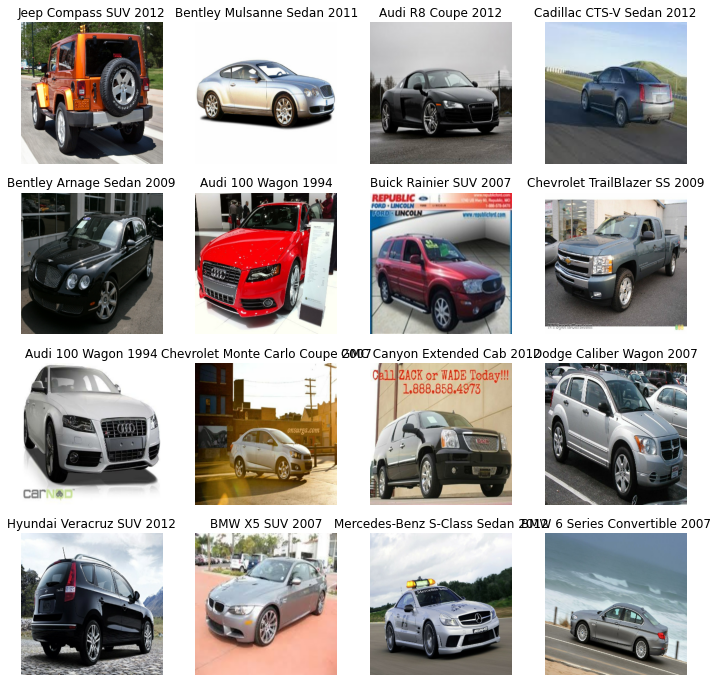

In [ ]:
# Load Class Names
names = pandas.read_csv('/content/kaggle/names.csv', header=None)
class_names = names.values.flatten()

data_dir = "/content/kaggle/car_data/car_data"
batch_size = 128;

# IMPORTANT: Depends on what pre-trained model you choose, 
#   you will need to change these dimensions accordingly
img_height = 299; 
img_width = 299;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + '/train',
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir+ '/test',
    image_size = (img_height, img_width),
    batch_size = batch_size
)

# Preview some pictures
n_rows = 4
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in train_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[labels[i]], fontsize = 12)

plt.subplots_adjust(wspace=.2, hspace=.2)

In [ ]:
# Clear Session
tf.keras.backend.clear_session()

# Model Set Up
model = tf.keras.applications.InceptionV3(weights='imagenet', 
                                          include_top=False)

# Adding Additional Layers
avg = tf.keras.layers.GlobalAveragePooling2D()(model.output)
output = tf.keras.layers.Dense(len(class_names), activation='softmax')(avg)
model = tf.keras.Model(inputs = model.input, outputs = output)

# Learning Rate Schedule
def lr_schedule(epoch):
  lrate = 0.001
  if epoch > 10:
    lrate = 0.0005
  if epoch > 20:
    lrate = 0.0001
  return lrate

# Define the number of training layers
for layer in model.layers:
  layer.trainable = True

# Model Compile
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

# Call back early stop and learning rate schedule
callback = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                             patience = 10,
                                             restore_best_weights = False) \
            , tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)]

# Fit the History
history = model.fit(train_ds, 
                    validation_data = validation_ds,
                    epochs = 100, 
                    callbacks = callback)

87916544/87910968 [==============================] - 1s 0us/step
Epoch 1/100
64/64 [==============================] - 264s 3s/step - loss: 4.7056 - accuracy: 0.0673 - val_loss: 5.1943 - val_accuracy: 0.0323
Epoch 2/100
64/64 [==============================] - 202s 3s/step - loss: 1.8679 - accuracy: 0.5014 - val_loss: 4.2467 - val_accuracy: 0.1211
Epoch 3/100
64/64 [==============================] - 201s 3s/step - loss: 0.7806 - accuracy: 0.7849 - val_loss: 3.1603 - val_accuracy: 0.2741
Epoch 4/100
64/64 [==============================] - 201s 3s/step - loss: 0.3883 - accuracy: 0.8847 - val_loss: 2.5794 - val_accuracy: 0.3669
Epoch 5/100
64/64 [==============================] - 201s 3s/step - loss: 0.2415 - accuracy: 0.9344 - val_loss: 2.1740 - val_accuracy: 0.5029
Epoch 6/100
64/64 [==============================] - 203s 3s/step - loss: 0.1328 - accuracy: 0.9662 - val_loss: 1.4364 - val_accuracy: 0.6267
Epoch 7/100
64/64 [==============================] - 201s 3s/step - loss: 0.1038 - 

In [ ]:
# Evaluation
model.evaluate(validation_ds)

63/63 [==============================] - 60s 894ms/step - loss: 0.4930 - accuracy: 0.8781


[0.49297577142715454, 0.8781245946884155]

### DenseNet 201

In [ ]:
# Load Class Names
names = pandas.read_csv('/content/kaggle/names.csv', header=None)
class_names = names.values.flatten()

data_dir = "/content/kaggle/car_data/car_data"
batch_size = 128;

# IMPORTANT: Depends on what pre-trained model you choose, 
#   you will need to change these dimensions accordingly
img_height = 224; 
img_width = 224;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + '/train',
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir+ '/test',
    image_size = (img_height, img_width),
    batch_size = batch_size
)

# Preview some pictures
n_rows = 4
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in train_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[labels[i]], fontsize = 12)

plt.subplots_adjust(wspace=.2, hspace=.2)

In [ ]:
# Clear Session
tf.keras.backend.clear_session()

# Model Set Up
model = tf.keras.applications.DenseNet201(weights='imagenet', 
                                          include_top=False)

# Adding Additional Layers
avg = tf.keras.layers.GlobalAveragePooling2D()(model.output)
output = tf.keras.layers.Dense(len(class_names), activation='softmax')(avg)
model = tf.keras.Model(inputs = model.input, outputs = output)

# Learning Rate Schedule
def lr_schedule(epoch):
  lrate = 0.001
  if epoch > 10:
    lrate = 0.0005
  if epoch > 20:
    lrate = 0.0001
  return lrate

# Define the number of training layers
for layer in model.layers:
  layer.trainable = True

# Model Compile
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

# Call back early stop and learning rate schedule
callback = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                             patience = 10,
                                             restore_best_weights = False) \
            , tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)]

# Fit the History
history = model.fit(train_ds, 
                    validation_data = validation_ds,
                    epochs = 100, 
                    callbacks = callback)